In [5]:
%autoreload
import os

import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Auxiliar funcs

In [6]:
def progression_slopes(df_input,
                       subject_id_col='subject_id',
                       time_col='months_since_first_session',
                       target_col='fvcPercPred_2019'):
    """
    Parámetros:
    - df_input: DataFrame que contiene los datos de los sujetos.
    - subject_id_col: Nombre de la columna que identifica al sujeto.
    - time_col: Nombre de la columna que representa la diferencia en tiempo desde la primera sesión.
    - target_col: Nombre de la columna objetivo actual (debe ser la columna '_t' del objetivo).
    
    Retorna:
    - results_df: DataFrame con la información del ajuste para cada sujeto.
    """
    # Crear una copia del DataFrame
    df = df_input.copy()

    # Lista para almacenar los resultados
    results = []

    # Iterar sobre cada sujeto
    for subject, group in df.groupby(subject_id_col):
        n_sessions = len(group)

        # Manejar casos con menos de 2 datos
        if n_sessions < 2:
            print(f"Sujeto que no puedo calcular slope por tener menos de 2 sesiones: {subject}")
            results.append({
                subject_id_col: subject,
                'slope': np.nan,
                'intercept': np.nan,
                'r_squared': np.nan,
                'rmse': np.nan,
                'n_sessions': n_sessions,
                'timespan_reg': group[time_col].max() if n_sessions > 0 else np.nan
            })
            continue

        # Variables independiente y dependiente
        X = group[[time_col]].values
        y = group[target_col].values

        # Ajustar la regresión lineal
        model = LinearRegression()
        model.fit(X, y)

        # Calcular métricas
        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = model.score(X, y)
        y_pred = model.predict(X)
        rmse = mean_squared_error(y, y_pred, squared=False)

        # Agregar resultados
        results.append({
            subject_id_col: subject,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'rmse': rmse,
            'n_sessions': n_sessions,
            'timespan_reg': group[time_col].max()
        })

    # Convertir resultados a un DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [7]:
def resample_based_on_order(group, step, **kwargs):
    # Los kwargs son solo para compatibilidad
    if step == 0:
        raise ValueError("El parámetro 'step' no puede ser 0. Por favor, elige un valor mayor que 0.")
    
    # Selecciona las filas con un índice basado en el salto `step`
    subsample = group.iloc[::step]
    return subsample

# Data

In [8]:
PATH = 'data'
FILE = 'data_fig5.csv'
df_data = pd.read_csv(os.path.join(PATH,FILE))

# Run

In [9]:
df_run = df_data.copy()

## Preprocessing

In [10]:
sns.set_context('talk', font_scale=1.05)

### Calcular las slopes ('slope_all')

df_run_slopes shape: (34, 7)


,subject_order,slope,n_sessions,timespan_reg
0,pALS 1,-1.179032,16,11.666667
1,pALS 10,-0.299309,36,12.033333
2,pALS 11,0.567506,47,14.933333


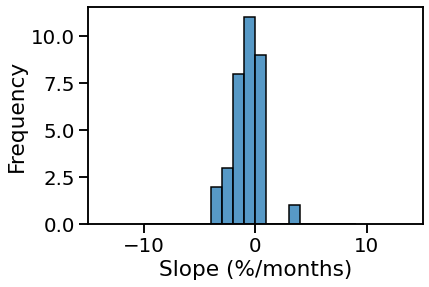

Numbre of subjects with NEGATIVE slope:  24


In [11]:
# calcular la progresión para el maximo de cada sujeto
df_run_slopes = progression_slopes(df_run[['subject_order', 
                                           'date_only', 
                                           'days_since_first_session',
                                           'months_since_first_session',
                                           'fvcPercPred_2019']],
                                   subject_id_col= 'subject_order',
                                   time_col = 'months_since_first_session')
print(f'df_run_slopes shape: {df_run_slopes.shape}')
display(df_run_slopes[['subject_order', 'slope', 'n_sessions', 'timespan_reg']].head(3))

with sns.plotting_context('talk', font_scale=1.2):
    _, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(df_run_slopes.slope, kde=False, ax=ax, bins= range(-10, 10, 1))
    ax.set_xlabel('Slope (%/months)')
    ax.set_ylabel('Frequency')
    ax.set_xlim(-15, 15)
    plt.show()

print("Numbre of subjects with NEGATIVE slope: ", df_run_slopes[df_run_slopes.slope <= 0].shape[0])

In [12]:
df_run.columns

Index(['subject_order', 'session_id_hash', 'date_only',
       'days_since_first_session', 'months_since_first_session',
       'days_since_first_valid_session', 'months_since_first_valid_session',
       'n_fvc_atleast_usable', 'pftType', 'fvcPercPred_2019', 'is_proctored',
       'slope_fvcPercPred_2019', 'intercept_fvcPercPred_2019',
       'y_pred_fvcPercPred_2019'],
      dtype='object')

In [13]:
df_run = df_run[[#'subject_id', 
                 'subject_order',
                 'session_id_hash',
                 'date_only',
                 'fvcPercPred_2019',
                 'days_since_first_session',
                 'months_since_first_session',
                 'days_since_first_valid_session',
                 'months_since_first_valid_session']].copy()

print(f'Shape df_run: {df_run.shape}')
df_run = pd.merge(df_run, df_run_slopes, on='subject_order')

# Add timespan as the max-min range in days
df_run['session_frecuency'] = df_run.groupby('subject_order').days_since_first_session.transform(lambda x: (x.max()-x.min())/len(x))

# Consolido lo que no cambia en el df_run_slopes
df_run_slopes = df_run.drop_duplicates(subset=['subject_order']).drop(columns=['date_only',
                                                                            'session_id_hash',
                                                                            'fvcPercPred_2019',
                                                                            'days_since_first_session',
                                                                            'months_since_first_session',
                                                                            'days_since_first_valid_session',
                                                                            'months_since_first_valid_session']).reset_index(drop=True).copy()

# Only negative slope
print('Drop subjects with negative slopes:')
df_run.query('slope <= 0', inplace=True)
print(f'N subjects: {df_run.subject_order.nunique()}')
df_run.rename(columns={'timespan': 'max_real_timespan', 'slope': 'slope_all'}, inplace=True)
print(f'Shape df_run: {df_run.shape}')
df_run.head(1)

Shape df_run: (742, 8)
Drop subjects with negative slopes:
N subjects: 24
Shape df_run: (489, 15)


,subject_order,session_id_hash,date_only,fvcPercPred_2019,days_since_first_session,months_since_first_session,days_since_first_valid_session,months_since_first_valid_session,slope_all,intercept,r_squared,rmse,n_sessions,timespan_reg,session_frecuency
0,pALS 31,d198f225e1ad61f6db090ff9a11697f4578bbab87f237e...,2023-03-08,83.0,29,0.966667,0,0.0,-3.552866,89.196843,0.752561,3.494797,20,7.733333,10.15


## Example

In [14]:
SUBJ = 'pALS 36'
print(df_run.query("subject_order == @SUBJ")['subject_order'].values[0])

df_subj_first_sessions = df_run[df_run.days_since_first_session < 90].query('subject_order == @SUBJ')

df_subj_first_sessions_slope = progression_slopes(df_subj_first_sessions, subject_id_col='subject_order')
display(df_subj_first_sessions_slope)

df_subj = df_run.query('subject_order == @SUBJ').copy()
df_subj_slope = progression_slopes(df_subj,  subject_id_col='subject_order')
display(df_subj_slope)

pALS 36


,subject_order,slope,intercept,r_squared,rmse,n_sessions,timespan_reg
0,pALS 36,-0.493192,78.229584,0.009791,4.276482,9,2.8


,subject_order,slope,intercept,r_squared,rmse,n_sessions,timespan_reg
0,pALS 36,-1.764098,79.887463,0.439968,4.176792,24,7.266667


# Model

## Subsampling and fit

In [15]:
# Fixed steps
all_steps     = [1, 2, 4]
rename_freq = {1: 'Full Samp.', 2: '50% Samp.', 4: '25% Samp.'}

all_timespans = np.arange(30, 181, 30)  # Timespans en días
time_col_reg = 'months_since_first_session'
all_auxs = {}

# Lista para almacenar los resultados
results = []

# Iterar sobre frecuencias y timespans
for freq in all_steps:
    all_auxs[freq] = {}
    for ts in all_timespans:
        print(f"--------------- freq: {freq}, timespan: {ts} ------------------------- ")
        # Seleccionar datos hasta el límite de días
        df_run_tmp = df_run[df_run['days_since_first_valid_session'] <= ts].copy()
               
        # Opcion 2: Aplicar resampleo fijo por orden
        df_aux = (df_run_tmp.groupby('subject_order')
                  .apply(lambda x: resample_based_on_order(x, step=freq))
                  .reset_index(drop=True))
        
        all_auxs[freq][ts] = df_aux.copy()
        all_auxs[freq][ts]['timespan'] = all_auxs[freq][ts].groupby('subject_order').days_since_first_session.transform(lambda x: (x.max()-x.min()))
        all_auxs[freq][ts]['session_frecuency'] = all_auxs[freq][ts].groupby('subject_order').days_since_first_session.transform(lambda x: (x.max()-x.min())/len(x))

        # Ajustar regresiones
        fit = progression_slopes(df_aux, subject_id_col='subject_order')
        fit['resample_freq'] = freq
        fit['resample_timespan'] = ts
        fit = fit.merge(all_auxs[freq][ts][['subject_order','timespan','session_frecuency']].drop_duplicates('subject_order'), on='subject_order')
        
        # Almacenar resultados
        results.append(fit)

# Concatenar todos los resultados
df_results_time = pd.concat(results, ignore_index=True)
print(df_results_time.shape)

total_subjects = df_results_time.dropna(subset=['slope']).groupby(['resample_freq', 'resample_timespan'])['subject_order'].count().reset_index().pivot_table(index='resample_freq', columns='resample_timespan')

--------------- freq: 1, timespan: 30 ------------------------- 
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 1
--------------- freq: 1, timespan: 60 ------------------------- 
--------------- freq: 1, timespan: 90 ------------------------- 
--------------- freq: 1, timespan: 120 ------------------------- 


--------------- freq: 1, timespan: 150 ------------------------- 
--------------- freq: 1, timespan: 180 ------------------------- 
--------------- freq: 2, timespan: 30 ------------------------- 
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 1
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 10
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 12
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 20
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 4
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 50
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 6
--------------- freq: 2, timespan: 60 ------------------------- 
Sujeto que no puedo calcular slope por tener menos de 2 sesiones: pALS 50
--------------- freq: 2, timespan: 90 ------------------------- 
--------------- freq: 2, timespan: 120 ------------------------- 
--------------- fr

In [16]:
slopes_subjects = df_run_slopes[['subject_order', 'slope', 'timespan_reg']]

# Merge con ground truth (fuera del ciclo)
df_results_time = df_results_time.merge(
    slopes_subjects,
    on='subject_order',
    how='left',
    suffixes=('', '_all')
)

# Calcular métricas adicionales
df_results_time['slope_abs_diff'] = np.abs(df_results_time['slope_all'] - df_results_time['slope'])
df_results_time['slope_diff'] = df_results_time['slope_all'] - df_results_time['slope']
df_results_time['resample_months'] = (df_results_time['resample_timespan'] / 30).astype(int)

# Contar sujetos únicos por combinación de frecuencia y timespan
df_results_time['n_subjects'] = df_results_time.groupby(['resample_freq', 'resample_timespan'])['subject_order'].transform('nunique')

# Mostrar resultados
print(f'--> Dropeando sujetos que no se les pudo calcular la slope: {df_results_time.shape} ---')
df_results_time.dropna(subset=['slope'],inplace=True)
print(f"-- Shape: {df_results_time.shape}")
df_results_time.head(3)

--> Dropeando sujetos que no se les pudo calcular la slope: (432, 17) ---
-- Shape: (396, 17)


,subject_order,slope,intercept,r_squared,rmse,n_sessions,timespan_reg,resample_freq,resample_timespan,timespan,session_frecuency,slope_all,timespan_reg_all,slope_abs_diff,slope_diff,resample_months,n_subjects
1,pALS 10,-4.285714,109.857143,1.000000,0.000000e+00,2,0.433333,1,30,7,3.5,-0.299309,12.033333,3.986405,3.986405,1,24
2,pALS 12,-17.142857,132.000000,1.000000,1.421085e-14,2,1.633333,1,30,7,3.5,-0.110660,11.666667,17.032197,17.032197,1,24
3,pALS 17,7.652812,93.177669,0.917751,7.566063e-01,5,0.933333,1,30,28,5.6,-0.156109,8.866667,7.808921,-7.808921,1,24


## Results (sample size)

In [17]:
from scipy.stats import norm
from itertools import product
def estimate_sample_size(sample_mean,
                         sample_std,
                         power=0.9,
                         alpha=0.05,
                         percentage_difference=0.3):
    
    # power = 0.85
    # alpha = 0.05
    mean_difference = sample_mean * percentage_difference
    standard_error = sample_std

    power_z = norm.ppf(power)
    alpha_z = abs(norm.ppf(alpha / 2))
    effect_size = mean_difference / standard_error
    N = ((power_z + alpha_z) / effect_size) ** 2
    N = np.ceil(N)
    #print(f"The estimated sample size is {N}")
    
    return int(N)

sample_size_df = []
estimator_col = 'slope'
# estimator_col = 'slope_diff'

for freq, ts in product(all_steps, all_timespans):
    df_tmp = df_results_time.query('resample_freq==@freq and resample_timespan==@ts').copy()
    df_tmp.dropna(subset=['slope'])
    sample_mean = df_tmp[estimator_col].mean()
    sample_standard_error = df_tmp[estimator_col].std()
    
    n_sample_size = estimate_sample_size(sample_mean, sample_standard_error)
    n_subjs_sample = df_tmp.subject_order.nunique()
    sample_size_df.append({'resample_freq': freq,
                           'resample_timespan': ts,
                           'total_subjects': n_subjs_sample,
                           'estimated_sample_size': n_sample_size,
                           })
                          
sample_size_df = pd.DataFrame(sample_size_df)

In [18]:
sample_size_df['resample_freq_sess'] = sample_size_df['resample_freq'].replace(rename_freq)

# Orden deseado
# desired_order = ['4 sess/month', '2 sess/month', '1 sess/month']
desired_order = rename_freq.values()

# Tabla de Sample Size
print("--> Tabla de Sample Size (Rutkove et al):")
sample_size_table = sample_size_df.pivot_table(
    values='estimated_sample_size', 
    columns='resample_timespan', 
    index='resample_freq_sess'
).reindex(desired_order)  # Reindexar para mantener el orden deseado
display(sample_size_table)

# Error Resample
df_months = df_results_time.copy()
df_months['resample_freq_sess'] = df_months['resample_freq'].replace(rename_freq)

error_resample = df_months.groupby(['resample_freq_sess', 'resample_timespan'])['slope_abs_diff'].aggregate(['mean']).unstack()
error_resample.columns = error_resample.columns.droplevel(0)
error_resample = error_resample.reindex(desired_order)  # Reindexar
print("--> Tabla de MAEs (heatmap):")
display(error_resample.round(2))

# Tabla de frecuencia de sujetos
session_freq_df = df_months.groupby(['resample_freq_sess', 'resample_timespan'])['session_frecuency'].aggregate(['mean']).unstack()
session_freq_df.columns = session_freq_df.columns.droplevel(0)
session_freq_df = session_freq_df.reindex(desired_order)  # Reindexar
print('--> Tabla de frecuencia de sesiones (sesiones por mes)')
display((30/session_freq_df).round(3))

# Sujetos
print("--> Tabla de sujetos en cada grupo:")
display(total_subjects)

# Tabla de medias de la slope
slopes_resample_mean = df_months.groupby(['resample_freq_sess', 'resample_timespan'])['slope'].aggregate(['mean']).unstack()
slopes_resample_mean.columns = slopes_resample_mean.columns.droplevel(0)
slopes_resample_mean = slopes_resample_mean.reindex(desired_order)  # Reindexar
print("--> Tabla de medias de la slope:")
display(slopes_resample_mean.round(3))

# Tabla de desvíos de la slope
slopes_resample_std = df_months.groupby(['resample_freq_sess', 'resample_timespan'])['slope'].aggregate(['std']).unstack()
slopes_resample_std.columns = slopes_resample_std.columns.droplevel(0)
slopes_resample_std = slopes_resample_std.reindex(desired_order)  # Reindexar
print("--> Tabla de desvíos de la slope:")
display(slopes_resample_std.round(3))

# Tabla de totales de sesiones
slopes_resample_std = df_months.groupby(['resample_freq_sess', 'resample_timespan'])['n_sessions'].aggregate(['mean']).unstack()
slopes_resample_std.columns = slopes_resample_std.columns.droplevel(0)
slopes_resample_std = slopes_resample_std.reindex(desired_order)  # Reindexar
print("--> Tabla de promedio del total de sesiones:")
display(slopes_resample_std.round(3))

# Tabla de totales de sesiones
slopes_resample_std = df_months.groupby(['resample_freq_sess', 'resample_timespan'])['n_sessions'].aggregate(['sum']).unstack()
slopes_resample_std.columns = slopes_resample_std.columns.droplevel(0)
slopes_resample_std = slopes_resample_std.reindex(desired_order)  # Reindexar
print("--> Tabla de total de sesiones:")
display(slopes_resample_std.round(3))



--> Tabla de Sample Size (Rutkove et al):


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,1318,2421,1875,507,273,109
50% Samp.,711,1118,4087,632,402,111
25% Samp.,451,509,13437,5543,3019,208


--> Tabla de MAEs (heatmap):


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,15.41,7.62,1.88,1.51,1.16,0.68
50% Samp.,9.76,4.03,2.02,1.57,1.22,0.67
25% Samp.,6.81,6.10,3.02,1.67,1.59,0.94


--> Tabla de frecuencia de sesiones (sesiones por mes)


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,5.511,3.494,2.793,2.644,2.555,2.352
50% Samp.,3.174,2.130,1.673,1.518,1.454,1.309
25% Samp.,2.386,1.646,1.180,0.999,0.926,0.836


--> Tabla de sujetos en cada grupo:


subject_order                    
resample_timespan           30  60  90  120 150 180
resample_freq                                      
1                            23  24  24  24  24  24
2                            17  23  24  24  24  24
4                             7  18  22  23  23  24

--> Tabla de medias de la slope:


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,8.507,5.443,-0.688,-1.172,-1.359,-1.288
50% Samp.,5.658,1.414,-0.489,-1.045,-1.155,-1.219
25% Samp.,4.210,3.270,0.417,-0.383,-0.514,-1.188


--> Tabla de desvíos de la slope:


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,28.583,24.784,2.757,2.442,2.077,1.239
50% Samp.,13.956,4.375,2.894,2.430,2.142,1.187
25% Samp.,8.266,6.823,4.473,2.641,2.612,1.583


--> Tabla de promedio del total de sesiones:


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,3.609,5.917,8.375,10.917,12.667,14.583
50% Samp.,2.412,3.261,4.500,5.708,6.625,7.583
25% Samp.,2.000,2.111,2.682,3.217,3.609,4.000


--> Tabla de total de sesiones:


resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,83,142,201,262,304,350
50% Samp.,41,75,108,137,159,182
25% Samp.,14,38,59,74,83,96


# Figure

Text(951.5, 0.5, 'Sample %')

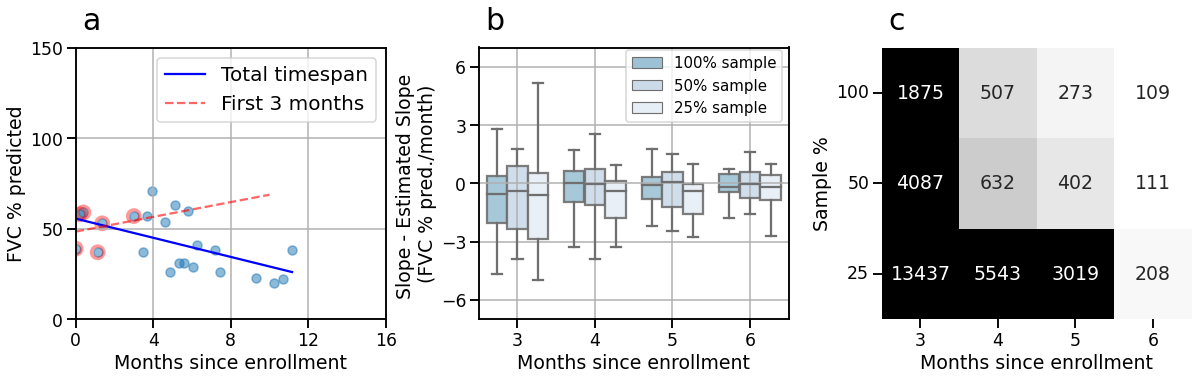

In [19]:
fig, axs = plt.subplots(nrows=1, 
                        ncols=3,
                        gridspec_kw={'width_ratios': [1, 1, 1], 
                                     'height_ratios': [1],
                                     'wspace': 0.3},
                        figsize=(20, 5))

#----------------------------------
# Figura A: Ejemplo
# Plot early slope
ax = axs[0]
ax.text(0.02, 1.15, 'a', fontsize=30, transform=ax.transAxes, va='top', ha='left')

s = 'pALS 45'
data_subj_all = df_run.query('subject_order == @s')
slope_all, intercept_all = df_run_slopes.query('subject_order ==@s')[['slope', 'intercept']].values[0]
x_all = data_subj_all.months_since_first_valid_session.values
y_all = data_subj_all.fvcPercPred_2019.values 
y_all_pred = x_all * slope_all + intercept_all    
    
# Plot ground truth slope
ax.plot(x_all, 
        y_all_pred, 
        color='blue', 
        label='Total timespan')

# Scatter plot for all data
ax.scatter(x_all,
            y_all, 
            color=sns.color_palette()[0], 
            alpha=0.5)

# EARLY
data_subj_early = df_run.query('subject_order == @s and months_since_first_session<=3')
slope_early, intercept_early = df_results_time.query('resample_timespan == 90 and resample_freq==1 and subject_order ==@s')[['slope', 'intercept']].values[0]
x_early = data_subj_early.months_since_first_valid_session.values
y_early = data_subj_early.fvcPercPred_2019.values 
y_early_pred = np.append(x_early, 10) * slope_early + intercept_early

# Plot predicted progression early data
ax.plot(np.append(x_early, 10), 
        y_early_pred,
        linestyle='--', 
        color='red', 
        alpha=0.6,
        label='First 3 months'
)

# Scatter plot for early data
ax.scatter(x_early, 
            y_early, 
            edgecolor='red', 
            facecolor='none', 
            s=150, 
            linewidths=3.5, 
            alpha=0.4,
    )

# Configure plot
ax.set(xlabel='Months since enrollment', ylabel='FVC % predicted', xlim=(0, 16), ylim=(0, 150.1))
ax.grid(True)
ax.set_xticks(np.array([0,4,8,12,16]))
ax.set_yticks([0,50,100,150])
ax.legend(fontsize=20)

#----------------------------------
# Figura B: 
# Scatter plot for early data
ax = axs[1]
ax.text(0.02, 1.15, 'b', fontsize=30, transform=ax.transAxes, va='top', ha='left')

hue_order = sorted(df_results_time['resample_freq'].unique(), reverse=False)
num_categories = len(hue_order)
colors = plt.cm.Blues(np.linspace(0.1, 0.4, num_categories))[::-1]  

df_boxplot = df_results_time.copy()
df_boxplot.dropna(subset=['slope'], inplace=True)
sns.boxplot(x='resample_timespan',
            y='slope_diff',
            hue='resample_freq',
            fliersize=0,
            ax = ax,
            hue_order=hue_order,
            data=df_boxplot.query('resample_timespan <= 180 and resample_timespan >= 90'),
            palette=colors,
            showcaps=True,
            boxprops={'alpha': 0.9}
            )

ax.set_ylabel('Slope - Estimated Slope \n(FVC % pred./month)')
ax.set_xlabel('Months since enrollment')
ax.set_ylim(-7,7)
ax.set_xticklabels((all_timespans[2:]/30).astype(int))
ax.set_yticks([-6,-3,0,3, 6])
# put the lenged outsied andchange the labesl with 'original', '14 days', '28 days'
legend_labels = rename_freq.values()
legend_labels = ['100% sample', '50% sample', '25% sample']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles,
          legend_labels,
          # loc='upper right',
          bbox_to_anchor=(.45, .7),
          fontsize=15)
ax.grid(True)

#----------------------------------
# Figura c: 
# ax = axs[2]
# ax.text(0.02, 1.15, 'c', fontsize=30, transform=ax.transAxes, va='top', ha='left')

# # Heatmap

# # rename the index
# error_resample.index = ['4', '2', '1']
# sns.heatmap(error_resample.iloc[:, 1:],
#             annot=True, 
#             cbar=False,
#             fmt=".2f", 
#             cmap="Greys", 
#             cbar_kws={'label': '\nMean Absolute Slope Difference'},
#             ax=ax)

# ax.set_xlabel('Months since enrollment')
# ax.set_ylabel('Frequency (sess/month)')

#----------------------------------
# Figura c: 
ax = axs[2]
ax.text(0.02, 1.15, 'c', fontsize=30, transform=ax.transAxes, va='top', ha='left')

sample_size_table_copy = sample_size_table.copy()
# sample_size_table_copy.rename(index={
#     'all sessions': 'Full Samp.',
#     '1 out of 2': '50% Samp.',
#     '1 out of 4': '25% Samp.'
sample_size_table_copy.rename(index={
    'Full Samp.':'100',
    '50% Samp.':'50',
    '25% Samp.':'25'
}, inplace=True)
sample_size_table_copy.rename(columns = {30: '1', 60: '2', 90: '3', 120: '4', 150: '5', 180: '6'},
                inplace=True)

sns.heatmap(sample_size_table_copy.iloc[:,2:],
            annot=True, 
            cbar=False,
            fmt="d", 
            cmap="Greys",
            vmax = 1800,
            ax=ax
)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xlabel('Months since enrollment')
ax.set_ylabel('Sample %')

# plt.tight_layout()
# plt.show()

In [20]:
sample_size_table.iloc[:,2:]

# Renombrar las filas del índice
sample_size_table.rename(index={
    'all sessions': 'Full Freq.',
    '1 out of 2': '50% Freq.',
    '1 out of 4': '25% Freq.'
})

resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,1318,2421,1875,507,273,109
50% Samp.,711,1118,4087,632,402,111
25% Samp.,451,509,13437,5543,3019,208


In [21]:
error_resample

resample_timespan,30,60,90,120,150,180
resample_freq_sess,,,,,,
Full Samp.,15.414512,7.624810,1.877386,1.509804,1.161108,0.679597
50% Samp.,9.759863,4.034353,2.018196,1.574902,1.215882,0.674539
25% Samp.,6.807992,6.099769,3.021149,1.667447,1.587694,0.944284
